In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import PerceiverAREstimator

In [3]:
dataset = get_dataset("electricity")

In [6]:
estimator = PerceiverAREstimator(
    depth=2,
    heads=1,
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*10,
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=25, accelerator='gpu', devices=1, precision="bf16"),
)

In [7]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | PerceiverARModel | 36.1 K
-------------------------------------------
36.1 K    Trainable params
0         Non-trainable par

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 6.21141 (best 6.21141), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/perceiverar/lightning_logs/version_6/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.86530 (best 5.86530), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/perceiverar/lightning_logs/version_6/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.59459 (best 5.59459), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/perceiverar/lightning_logs/version_6/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.58047 (best 5.58047), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/perceiverar/lightning_logs/version_6/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.50806 (best 5.50806), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/perceiverar/lightning

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [9]:
forecasts = list(forecast_it)

In [10]:
tss = list(ts_it)

In [11]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 5571.42it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [12]:
agg_metrics

{'MSE': 1786899.141427517,
 'abs_error': 8723193.055753708,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.7304233356678119,
 'MAPE': 0.09882304463669614,
 'sMAPE': 0.1038486984711897,
 'MSIS': 6.110520091266843,
 'QuantileLoss[0.1]': 3642090.4303850476,
 'Coverage[0.1]': 0.13226895119418486,
 'QuantileLoss[0.2]': 5755249.535795327,
 'Coverage[0.2]': 0.2662067942441775,
 'QuantileLoss[0.3]': 7221337.541206102,
 'Coverage[0.3]': 0.397196261682243,
 'QuantileLoss[0.4]': 8203070.339375221,
 'Coverage[0.4]': 0.5209167779261237,
 'QuantileLoss[0.5]': 8723193.033169838,
 'Coverage[0.5]': 0.6309709241952233,
 'QuantileLoss[0.6]': 8709557.680886673,
 'Coverage[0.6]': 0.7180870790683874,
 'QuantileLoss[0.7]': 8221996.214281925,
 'Coverage[0.7]': 0.8027184394006823,
 'QuantileLoss[0.8]': 7025424.078225534,
 'Coverage[0.8]': 0.8720701676309153,
 'QuantileLoss[0.9]': 4918710.050568199,
 'Coverage[0.9]': 0.9354695149087673,
 

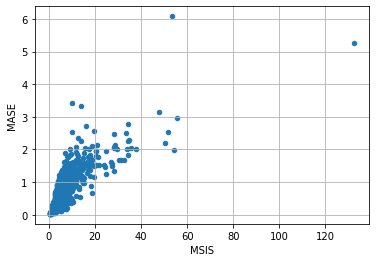

In [13]:
ts_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

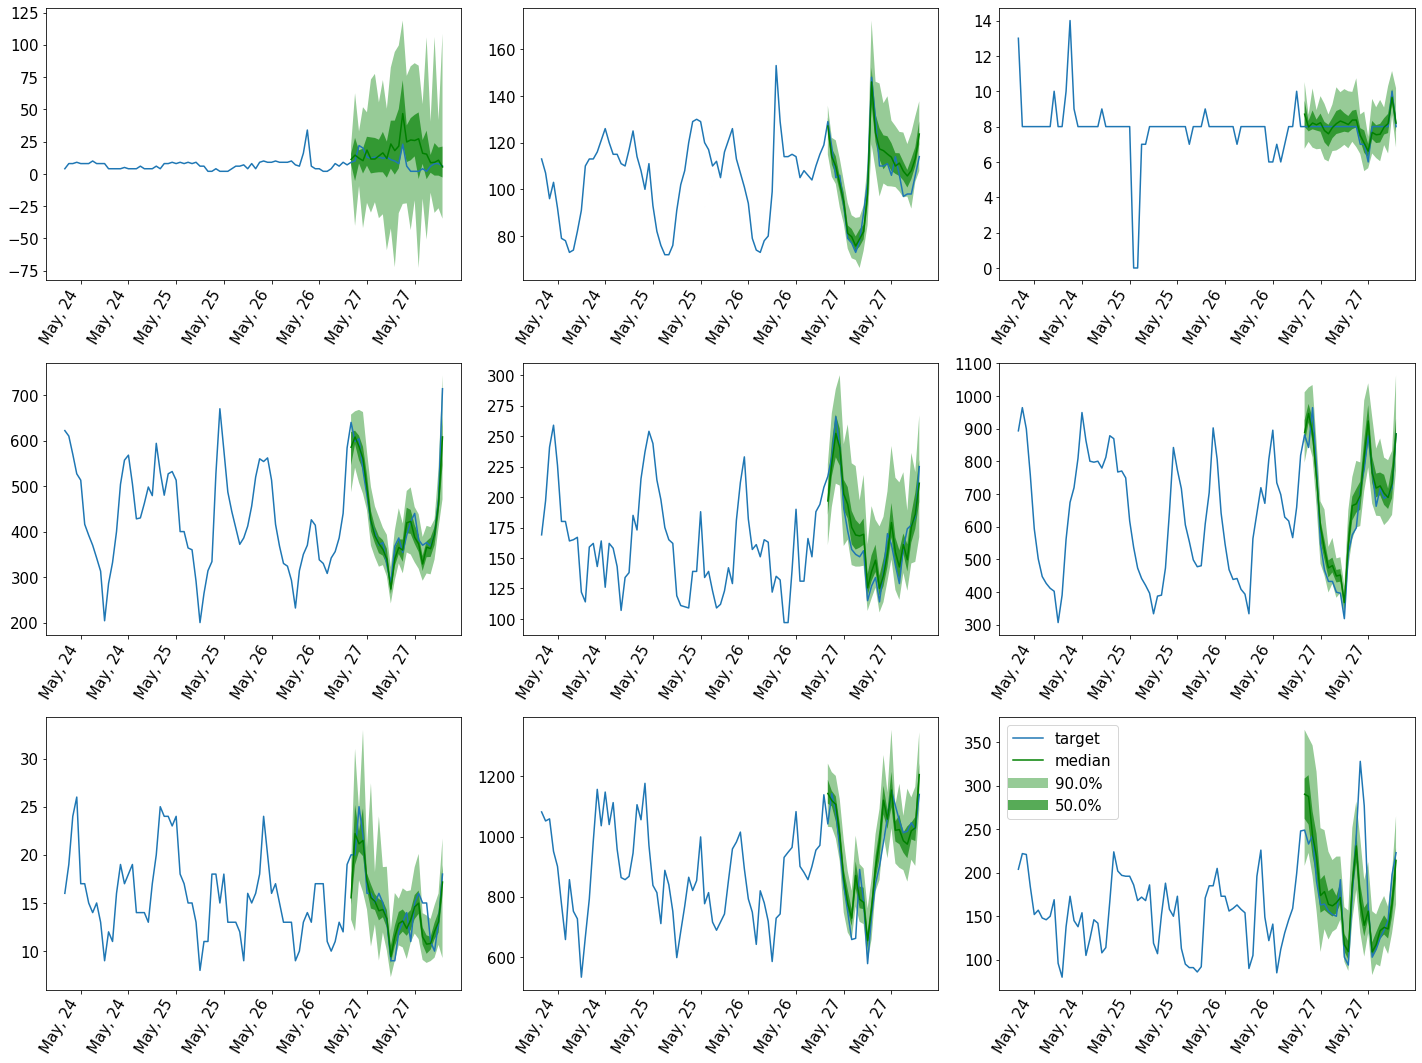

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()